In [ ]:
! pip3 install py4j==0.10.7
! pip3 install numpy==1.13.3 --user
! pip3 install xgboost --user
! pip3 install pdpbox --user

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
#from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [5]:
#Load and split the data
training_data = pd.read_csv("train.csv")
testing_data = pd.read_csv("test.csv")
costa_rica_data = training_data.drop(['Target'], axis=1)
costa_rica_target = training_data['Target']

In [7]:
#Split data into 70% train, 30% validation (test) split
X_train, X_test, y_train, y_test = train_test_split(costa_rica_data, costa_rica_target, test_size= 0.3, random_state=42)
X_train.shape

(6689, 142)

In [20]:
#Clean the data to either replace or remove string columns
X_train.select_dtypes(exclude=[np.number]).head()

,Id,idhogar,dependency,edjefe,edjefa
7856,ID_0318f001f,1ed926340,8,no,4
469,ID_7fd0d600c,8ac40302b,yes,9,no
2629,ID_c88c1a043,b7e81e326,yes,11,no
4692,ID_686b6ef41,1545448c1,no,no,11
9049,ID_333afef12,8cae1d205,2,no,no


In [50]:
X_train = X_train.drop(['Id', 'idhogar', 'dependency', 'edjefe', 'edjefa'], axis=1).fillna(0)
X_test = X_test.drop(['Id', 'idhogar', 'dependency', 'edjefe', 'edjefa'], axis=1).fillna(0)
X_train.head()

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
7856,0.0,0,4,1,1,0,0,0.0,2,3,...,12,16,144,81,0,64,9.000000,64.0,16.00000,144
469,300000.0,0,4,0,1,1,0,0.0,0,2,...,39,144,1521,16,81,4,1.777778,1.0,110.25000,1521
2629,0.0,0,5,0,1,1,1,2.0,1,1,...,35,121,1225,16,121,4,1.777778,1.0,121.00000,1225
4692,0.0,0,7,0,1,1,1,1.0,0,3,...,27,121,729,25,0,0,1.562500,0.0,163.84001,729
9049,50000.0,0,3,0,1,1,0,0.0,2,1,...,27,1,729,36,0,16,9.000000,4.0,0.25000,729


In [75]:
#Build ML pipeline to perform quick analysis with classification algorithms
def quick_eval(pipeline, X_train, y_train, X_test, y_test, verbose=True):
    '''More advanced pipeline that uses DecisionTree,
    RandomForest, XGBoost, CatBoost and LightGBM as estimators'''
    
    pipeline.fit(X_train, y_train)
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    
    train_score = pipeline.score(X_train, y_train)
    test_score = pipeline.score(X_test, y_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    s = [train_score, test_score, train_rmse, test_rmse, train_r2, test_r2]
    s_df = pd.DataFrame(s, columns=[pipeline.named_steps['classification'].__class__.__name__], 
                        index=['train_score', 'test_score', 'train_rmse', 'test_rmse',
                              'train_r2', 'test_r2'])
    return s_df
    
classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier()
]

score_df = pd.DataFrame()

for c in classifiers:
    pipe = Pipeline(steps = [
        ('minmax', MinMaxScaler()),
        ('classification', c)
    ])

    result_df = quick_eval(pipe, X_train, y_train, X_test, y_test)
    score_df = pd.concat([score_df, result_df], axis=1)
    
score_df

,DecisionTreeClassifier,RandomForestClassifier,XGBClassifier
train_score,1.000000,0.997309,0.745702
test_score,0.894003,0.870293,0.720711
train_rmse,0.000000,0.090678,0.886941
test_rmse,0.540868,0.622117,0.919910
train_r2,1.000000,0.991850,0.220222
test_r2,0.719408,0.628775,0.188322


Feature ranking:
1. feature 98 (0.053861)
2. feature 135 (0.050230)
3. feature 134 (0.035014)
4. feature 131 (0.025545)
5. feature 118 (0.025365)
6. feature 109 (0.024673)
7. feature 133 (0.024340)
8. feature 94 (0.022548)
9. feature 132 (0.021394)
10. feature 2 (0.019744)


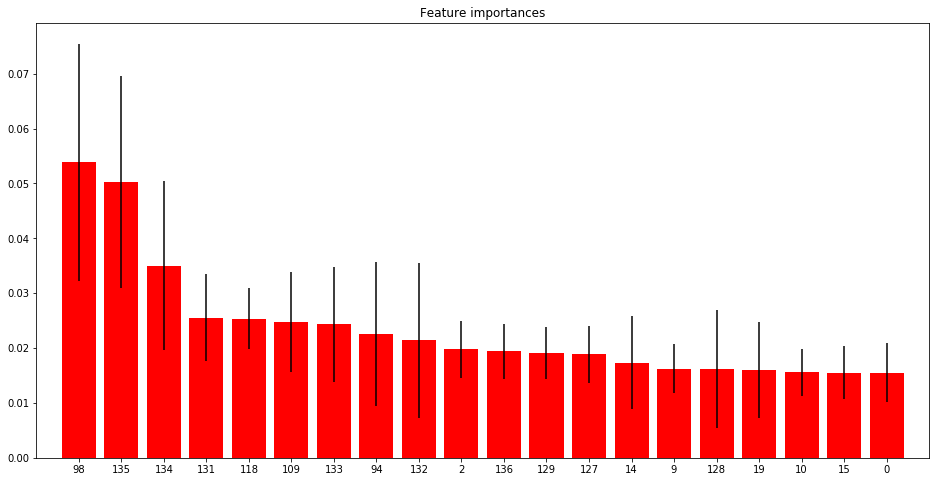

In [86]:
#Determine Feature Importance for RandomForestClassifier
import matplotlib.pyplot as plt

# Build a forest and compute the feature importances
forest = RandomForestClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(16,8))
plt.title("Feature importances")
plt.bar(range(20), importances[indices][:20],
       color="r", yerr=std[indices][:20], align="center")
plt.xticks(range(20), indices)
plt.xlim([-1, 20])
plt.show()

In [87]:
! pip install pdpbox

You are using pip version 9.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.



Random Forest
Accuracy on training set: 1.000
Accuracy on test set: 0.902

Random Forest - Max Depth = 3
Accuracy on training set: 0.651
Accuracy on test set: 0.635

Random Forest Feature Importance


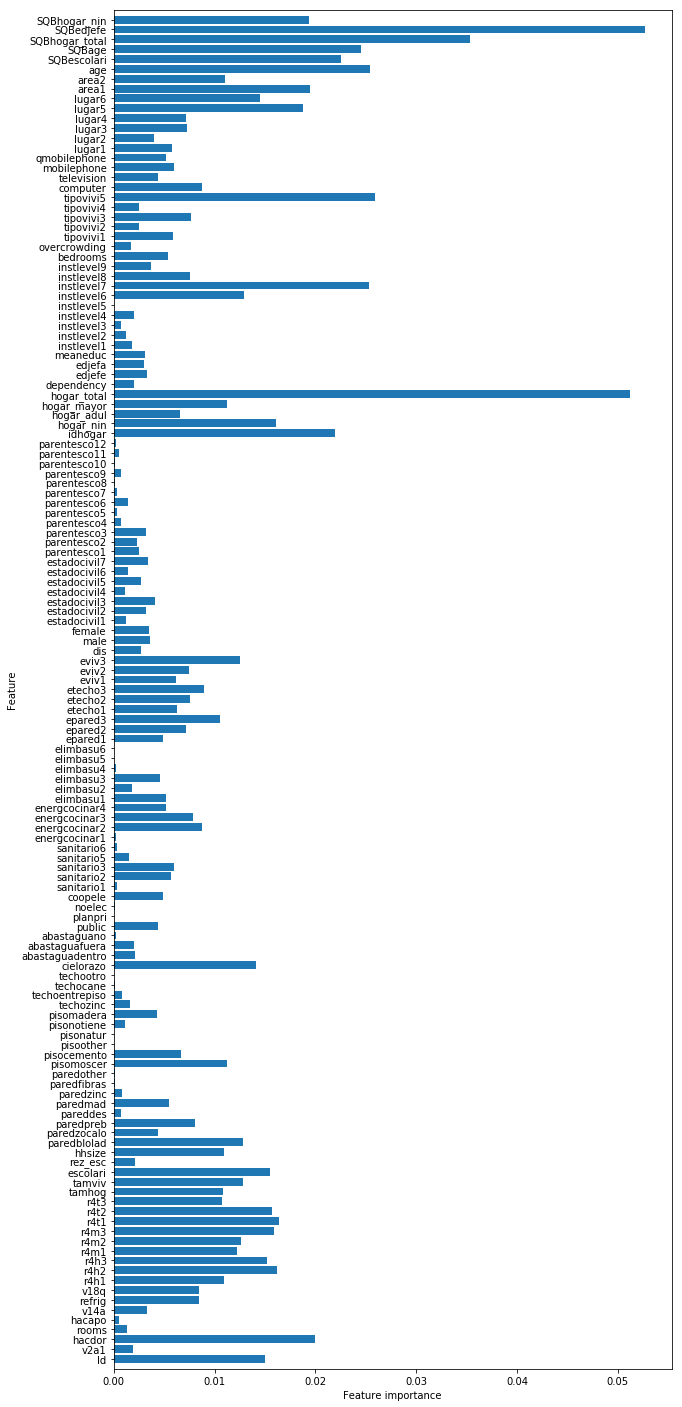

In [96]:
costa_rica_features = [x for i,x in enumerate(costa_rica_data) if i!=8]

def plot_feature_importances_costa(model):
    plt.figure(figsize=(10,25))
    n_features = 137
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), costa_rica_features)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    plt.show()

rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)
print("")
print('Random Forest')
print("Accuracy on training set: {:.3f}".format(rf.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(rf.score(X_test, y_test)))

rf1 = RandomForestClassifier(max_depth=3, n_estimators=100, random_state=0)
rf1.fit(X_train, y_train)
print("")
print('Random Forest - Max Depth = 3')
print("Accuracy on training set: {:.3f}".format(rf1.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(rf1.score(X_test, y_test)))

print("")
print('Random Forest Feature Importance')
plot_feature_importances_costa(rf)